# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

Due to the ongoing circumstances regarding COVID-19 Bay Area jurisdictions and state of California have mandated residents shelter-in-place. For those that go outside it is recommended that people follow social distancing guidelines that suggest people remain 6 feet away from each other to avoid further spread of the novel coronavirus. However, this can often be difficult in many built environments where the space allocated to vehicles dwarfs the width of the sidewalk.

<img src="../img/tingvall-201411.jpg" />

![](../img/tingval-201411.jpg)<div align="center">*Pedestrian road space, by Claes Tingvall of the Swedish Road Administration. [Source](https://ggwash.org/view/36573/to-a-pedestrian-a-roads-a-tiny-space-with-danger-just-beside)*.</div>

To encourage social distancing [many cities around the world](https://www.theguardian.com/world/2020/apr/11/world-cities-turn-their-streets-over-to-walkers-and-cyclists) have converted road space from automotive traffic to pedestrians and bicyclists. Although many of these are just temporary closures, the increased space for non-vehicular travel is allowing residents to get exercise, fresh air, and access still-open essential buildings in a more sustainable way.

Oakland has been receptive to these needs and recently [identified 74 miles of streets](https://sf.streetsblog.org/2020/04/10/oakland-to-open-74-miles-of-streets-for-safe-biking-and-recreation/) to be cordoned off for non-automotive travel. Not all cities in the Bay Area are following suit though. Despite the decrease in vehicular travel and the need for increased sidewalk space [San Francisco has not closed streets](https://sf.streetsblog.org/2020/03/30/people-desperate-for-space-but-so-far-bay-area-officials-wont-open-streets/) and a [letter](https://docs.google.com/document/u/1/d/e/2PACX-1vQQkbtEb3s0bfUMcLUMeu1Oa4OWnmxK9hsRLIRfw3PznZYCsc7kpUZ9pjpHS1La9PWUswL7q9LGVG7q/pub) and [petition](https://docs.google.com/forms/d/e/1FAIpQLSdIXHpAjaZVu9hTSbRgx7z5YAtl3ZiNsJTw3WA3-awvywsd9w/viewform) to repurpose Berkeley’s bicycle boulevards has yet to gain traction.

This project builds on the need for additional street closures to create safe streets in the Bay Area during the pandemic. I use open-source bike share data from BayWheels to identify the most frequented biking paths by system users. Together with maps of existing and planned bicycle facilities these routes can serve as recommendations for jurisdictions in the Bay Area that are looking to close streets to vehicular traffic to promote social distancing.

### `0_Process_BayWheels_Trips`

**Datasets used:**
* [System data](https://www.lyft.com/bikes/bay-wheels/system-data) from Bay Wheels. We process only trips from February 2020 because it is the latest dataset available (most current station layout and trip flows).
* [Regional bicycle facilities](http://opendata.mtc.ca.gov/datasets/regional-bike-facilities?geometry=-122.400%2C37.800%2C-122.144%2C37.847) in the Bay Area. From the Metropolitan Transportation Commission.
* Census boundaries for California, including polygons for the state outline, census-designated places, and tracts.

**Notebook summary:**
* Import packages and data
* Identify unique origin-destination trip pairs in dataset
* Identify unique stations in the dataset
    * Create geospatial dataset with lat,lon of stations
    
    
* density of bike share stations in East Bay
    * gif with change over time?
    * heatmap of ridership times and dates?
* put O-Ds (unique) though OSMnx route to get most used routes (Feb 2020 only?)
* use to inform locaitons hwere street closures would be useful to encourage social distancing
    * overlay with bike boulevards and lanes
    * overlay with bus routes
    * overlay with SAFETrec bike crash locations?

**Additional reading:**
* "As New Yorkers seek open space, city will cut short car-free streets pilot" from [curbed.com](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* "How to open streets right during social distancing" from [streetsblog.org](https://usa.streetsblog.org/2020/04/08/how-to-open-streets-right-during-social-distancing)
* "NYC car-free streets pilot cut short" from [curbed.com](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* [This](https://twitter.com/jen_keesmaat/status/1248972266156720131) and other tweets by former Toronto Chief Planner Jennifer Keesmaat [@jen_keesmaat](https://twitter.com/jen_keesmaat)

**Alternate titles:** 
* Using open-source bike share trip data to inform social distancing street closures.
* Exploring locations for street-closures to promote social distancing during the COVID-19 pandemic using open-source bike share trip data.

### 0.0 Initialize notebook

In [1]:
# import csv
# import json
# import geojson
# import requests
import numpy as np
import pandas as pd
import geopandas as gpd
# from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# gbfs_stations = r'https://gbfs.baywheels.com/gbfs/en/station_information.json'
# gbfs_regions = r'https://gbfs.baywheels.com/gbfs/en/system_regions.json'

### 0.1 Load data

In [4]:
# load raw trip data
trips = pd.read_csv("../data/202002-baywheels-tripdata.csv", low_memory=False)

In [5]:
# load bicycle facilities in Bay Area
facilities = gpd.read_file("../data/regional_bike_facilities.geojson")

# class / class_type :
# 1 = 'Off-Street Shared-Use Path'
# 2 = 'Bike Lane'
# 3 = 'On-Street Bike Route'

In [21]:
# load census boundaries
outlines = gpd.read_file("zip://../data/cb_2016_us_state_500k.zip")
places = gpd.read_file("zip://../data/cb_2018_06_place_500k.zip")

In [1]:
# fig, ax = plt.subplots(figsize=(10,10))

# outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')
# # places.plot(ax=ax, color='white', edgecolor='black')
# facilities.plot(ax=ax, column='class_type')

# ax.set_xlim((-122.32, -122.2))
# ax.set_ylim((37.76, 37.9))

# plt.show()

## Heatmap
* http://seaborn.pydata.org/examples/heatmap_annotation.html
* https://seaborn.pydata.org/generated/seaborn.heatmap.html


* mess of code for [creating animations](https://stackoverflow.com/questions/46236902/redrawing-seaborn-figures-for-animations) in matplotlib
* simpler [animation](https://python-graph-gallery.com/340-scatterplot-animation/) in seaborn using gifs

In [10]:
import seaborn as sns
sns.set()

In [6]:
# truncate data to be list of trip counts by day of week (0-6) and hour of day (0-23)
trips['start_time'] = pd.to_datetime(trips.start_time, format='%Y-%m-%d %H:%M:%S.%f')
trips['day'] = trips['start_time'].dt.weekday
trips['hour'] = trips['start_time'].dt.hour
heatmap_df = trips.groupby(['day', 'hour']).start_time.count().reset_index()
heatmap_df.rename(columns={"start_time": "count"}, inplace=True)

In [7]:
# convert to long-form and rename index
heatmap_df = heatmap_df.pivot("day", "hour", "count")
heatmap_df.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
heatmap_df.index.name = 'day'

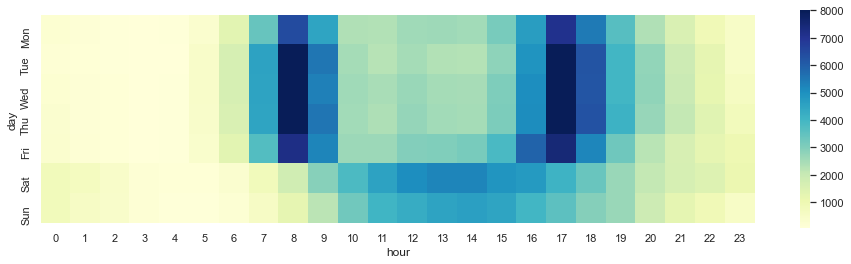

In [8]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(16, 4))
sns.heatmap(heatmap_df, 
            cmap="YlGnBu", 
            square=True, 
            vmax=8000,
            ax=ax)

### 0.2 Get unique OD pairs from trip table

The data provided by Bay Wheels contains the following fields:

    Trip Duration (seconds)
    Start Time and Date
    End Time and Date
    Start Station ID
    Start Station Name
    Start Station Latitude
    Start Station Longitude
    End Station ID
    End Station Name
    End Station Latitude
    End Station Longitude
    Bike ID
    User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

For this project I am only interested in counts of trips between unique origins and destinations, so below the data is grouped by start and end id, with the coordinates preserved.

In [9]:
# Group trips by Origin-Destination pair
trips_agg = trips.groupby(["start_station_id", "end_station_id"]).agg({'start_time':'count',
                                                                      'start_station_latitude': 'first',
                                                                      'start_station_longitude': 'first',
                                                                      'end_station_latitude': 'first',
                                                                      'end_station_longitude': 'first'})
# Reset index and rename counts column
trips_agg.reset_index(inplace=True)
trips_agg.rename(columns={"start_time": "count"}, inplace=True)

# Drop all trips that start and end in the same location. Although many bike share riders may 
# take roundtrips, whether for leisure or for errands that require returning to the point of 
# origin, these routes cannot be processed later and can be dropped from the dataset.
trips_agg = trips_agg.loc[trips_agg.start_station_id != trips_agg.end_station_id]

# Display aggregated dataframe
trips_agg.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
1,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915
2,3.0,5.0,27,37.786375,-122.404904,37.783899,-122.408445
3,3.0,6.0,13,37.786375,-122.404904,37.804770,-122.403234
4,3.0,8.0,6,37.786375,-122.404904,37.799953,-122.398525
5,3.0,9.0,3,37.786375,-122.404904,37.798572,-122.400869


### 0.3 Get unique stations from trip table

In [11]:
# subset data for only origins and relevant columns
trips_start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']]
trips_start.columns = ['station_id', 'name', 'lat', 'lon']

# subset data for only destinations and relevant columns
trips_end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
trips_end.columns = ['station_id', 'name', 'lat', 'lon']

# join origins and destinations, filter to only include unique/non-null values
stations = trips_start.append(trips_end)
stations.dropna(inplace=True)
stations.drop_duplicates(inplace=True)

# turn data into geospatial dataframe
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))

# view gdf
stations.head()

,station_id,name,lat,lon,geometry
0,176.0,MacArthur BART Station,37.828410,-122.266315,POINT (-122.26631 37.82841)
1,375.0,Grove St at Masonic Ave,37.774836,-122.446546,POINT (-122.44655 37.77484)
3,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,POINT (-122.26789 37.81607)
5,182.0,19th Street BART Station,37.809369,-122.267951,POINT (-122.26795 37.80937)
6,252.0,Channing Way at Shattuck Ave,37.865847,-122.267443,POINT (-122.26744 37.86585)


## Label stations by regions 
Using self-defined bounding boxes

In [12]:
from shapely.geometry import Polygon

In [13]:
# define a bounding boxes for bike share regions
regions = [{"name": "East Bay", "lat": [37.9, 37.9, 37.76, 37.76, 37.9], 
                                "lon": [-122.2, -122.32, -122.32, -122.2, -122.2]},
           {"name": "San Francisco", "lat": [37.81, 37.81, 37.71, 37.71, 37.81], 
                                     "lon": [-122.37, -122.48, -122.48, -122.37, -122.37]},
           {"name": "San Jose", "lat": [37.375, 37.375, 37.305, 37.305, 37.375], 
                                "lon": [-121.86, -121.925, -121.925, -121.86, -121.86]}]

# create empty gdf to store data
crs = 'epsg:4326'
bbox_gdf = gpd.GeoDataFrame(columns=["region", "geometry"], crs=crs)

# loop through regions, create bounding boxes for each one
for i in range(len(regions)):
    polygon_geom = Polygon(zip(regions[i]['lon'], regions[i]['lat']))
    bbox_gdf = bbox_gdf.append({'region': regions[i]['name'], 'geometry': polygon_geom}, ignore_index=True)

In [14]:
# # add regions to stations
# for index, row in bbox_gdf.iterrows():
#     stations[row['region']] = stations.within(bbox_gdf.loc[index, 'geometry'])

# # see new table
# stations.head()

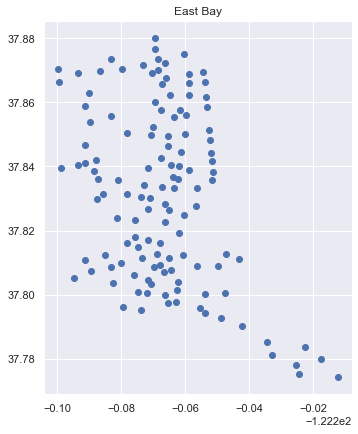

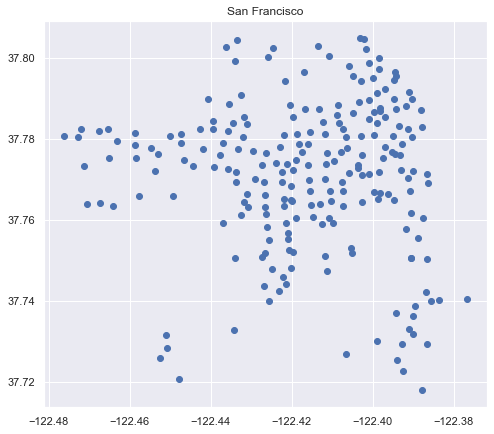

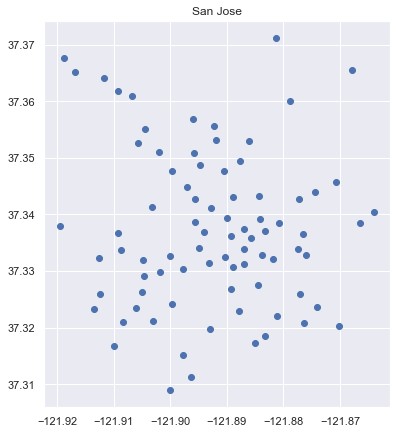

In [16]:
# map all three regions
# for i in range(len(regions)):
for index, row in bbox_gdf.iterrows():
    fig, ax = plt.subplots(figsize = (9,6))
    # stations.loc[trips_gdf[regions[i]['name']]==True].plot(ax=ax)
    stations.loc[stations.within(bbox_gdf.loc[index, 'geometry'])].plot(ax=ax)

    plt.tight_layout()
    # plt.title(regions[i]['name'])
    plt.title(row['region'])
    plt.show()

In [17]:
# create gdfs of only stations in the East Bay
# stations_eb = stations.loc[stations['East Bay']==True].copy()

# # create gdfs of only stations in San Francisco
# stations_sf = stations.loc[stations['San Francisco']==True].copy()

# # create gdfs of only stations in San Jose
# stations_sj = stations.loc[stations['San Jose']==True].copy()

In [18]:
# select only trips in the East Bay
# trips_eb = trips_agg[(trips_agg.start_station_id.isin(stations_eb.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_eb.station_id))]

# # select only trips in San Francisco
# trips_sf = trips_agg[(trips_agg.start_station_id.isin(stations_sf.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_sf.station_id))]

# # select only trips in San Jose
# trips_sj = trips_agg[(trips_agg.start_station_id.isin(stations_sj.station_id)) & 
#                      (trips_agg.end_station_id.isin(stations_sj.station_id))]

In [19]:
# trips_agg = trips_agg.merge(trips_gdf[['station_id', 'lat', 'lon']], 
#                             left_on="start_station_id", 
#                             right_on="station_id")
# trips_agg.drop(columns=['station_id'], inplace=True)
# trips_agg.rename(columns={'lat': 'start_lat', 'lon': 'start_lon'}, inplace=True)

# trips_agg = trips_agg.merge(trips_gdf[['station_id', 'lat', 'lon']], 
#                             left_on="end_station_id", 
#                             right_on="station_id")
# trips_agg.drop(columns=['station_id'], inplace=True)
# trips_agg.rename(columns={'lat': 'end_lat', 'lon': 'end_lon'}, inplace=True)

## OSMNx
* Get network for all locations around East Bay Bay Wheels (can repeat later for SF, San Jose)
* For each origin point use OSMnx to find the nearest network node
* For each destination point use OSMnx to find the nearest network node
* Calculate the shortest path between each origin/destination node pair, using nx.shortest_path
* Save the route to a MultiLineString wkt
* As the wkt is plain-text, just save this text to disk using any Python serialization method. Or assemble all the MultiLineStrings themselves into a geopandas GeoSeries and save that to disk as a shapefile or a GeoJSON file.

#### Sources:
* https://stackoverflow.com/questions/58257528/osmnx-shortest-path-for-a-set-of-origins-and-destinations
* https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id

https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
https://stackoverflow.com/questions/37428218/how-to-properly-apply-a-lambda-function-into-a-pandas-data-frame-column

In [20]:
# import OSMnx methods
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

In [21]:
# import timing methods
import time
from tqdm import tqdm

In [22]:
# working with East Bay data first, so define region name and tables to use
# region = "East Bay"
# trips = trips_eb.copy()
# stations = stations_eb.copy()

In [23]:
# # Define a bounding box
# bounds = bbox_gdf.loc[bbox_gdf.region==region].geometry.bounds
# north, south, east, west = bounds.maxy[0], bounds.miny[0], bounds.maxx[0], bounds.minx[0]

# # Create network from that bounding box. Setting network_type='bike' because 
# # we want on- and off-road bike paths for routing.
# G = ox.graph_from_bbox(north, south, east, west, network_type='bike')

# # Do not reproject the network yet, we want it in WGS84 for routing with our (lat,lon) coordinates

# # plot network
# # fig, ax = ox.plot_graph(G)

In [24]:
# # create empty array to store nodes
# nodes_list = []

# # loop though all stations, get nearest node, append to list
# for i in tqdm(range(len(stations))):
#     node = ox.get_nearest_node(G, (trips_gdf.iloc[i]['lat'], trips_gdf.iloc[i]['lon']))
#     nodes_list.append(node)

# # add list to origin and destination nodes to the dataframe
# stations['node'] = np.array(nodes_list)

In [30]:
nodes_df = pd.DataFrame(columns=['station_id', 'ox_node', 'region'])
networks = []
for index, row in bbox_gdf.iterrows():
    r = row['region']
    i = index
    print(f"Retrieving OSMnx network within {r}")
    
    # Define a bounding box for current region
    bounds = bbox_gdf.loc[bbox_gdf.region==r].geometry.bounds
    north, south, east, west = bounds.maxy[i], bounds.miny[i], bounds.maxx[i], bounds.minx[i]
    
    # Create network from that bounding box. Setting network_type='bike' because 
    # we want on- and off-road bike paths.
    G = ox.graph_from_bbox(north, south, east, west, network_type='bike')
    networks.append(G)
    
    print(f"Collecting OSMnx node ids within {r}")
    
    # Create empty array to store nodes
    nodes_list = []
    station_ids = []
    region_name = []
    
    # select all nodes in that region
    temp_gdf = stations.loc[stations.within(bbox_gdf.loc[i, 'geometry'])].copy()

    # loop though all trips, get nearest node and append to array
    for j in tqdm(range(len(temp_gdf))):
        node = ox.get_nearest_node(G, (temp_gdf.iloc[j]['lat'], temp_gdf.iloc[j]['lon']))
        nodes_list.append(node)
        station_ids.append(temp_gdf.iloc[j]['station_id'])
        region_name.append(r)

    # create dataframe with nearest nodes
    temp_df = pd.DataFrame({'station_id': station_ids,
                            'ox_node': nodes_list,
                            'region': region_name}) 
    nodes_df = nodes_df.append(temp_df)

Retrieving OSMnx network within East Bay


  0%|                                                                                          | 0/128 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:18<00:00,  7.04it/s]


Retrieving OSMnx network within San Francisco


  0%|                                                                                          | 0/226 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 226/226 [00:23<00:00,  9.64it/s]


Retrieving OSMnx network within San Jose


  4%|███                                                                                | 3/82 [00:00<00:03, 25.25it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:05<00:00, 15.50it/s]


In [33]:
# merge nearest nodes df with stations gdf
stations = stations.merge(nodes_df, on="station_id", how="left")
stations.head()

In [32]:
# stations.merge(temp_df, on="station_id", how="left")

In [49]:
stations.head()

,station_id,name,lat,lon,geometry,ox_node,region
0,176.0,MacArthur BART Station,37.828410,-122.266315,POINT (-122.26631 37.82841),4096114902,East Bay
1,375.0,Grove St at Masonic Ave,37.774836,-122.446546,POINT (-122.44655 37.77484),65356407,San Francisco
2,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,POINT (-122.26789 37.81607),283261632,East Bay
3,182.0,19th Street BART Station,37.809369,-122.267951,POINT (-122.26795 37.80937),2389106017,East Bay
4,252.0,Channing Way at Shattuck Ave,37.865847,-122.267443,POINT (-122.26744 37.86585),53063548,East Bay


In [40]:
print(len(stations))
print(len(stations[stations.region=="East Bay"].ox_node))
print(len(stations[stations.region=="San Francisco"].ox_node))
print(len(stations[stations.region=="San Jose"].ox_node))

438
128
228
82


In [47]:
stations.region.unique()

array(['East Bay', 'San Francisco', 'San Jose'], dtype=object)

In [48]:
trips_agg

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
1,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915
2,3.0,5.0,27,37.786375,-122.404904,37.783899,-122.408445
3,3.0,6.0,13,37.786375,-122.404904,37.804770,-122.403234
4,3.0,8.0,6,37.786375,-122.404904,37.799953,-122.398525
5,3.0,9.0,3,37.786375,-122.404904,37.798572,-122.400869
...,...,...,...,...,...,...,...
24400,512.0,6.0,1,37.789688,-122.440688,37.804770,-122.403234
24401,512.0,31.0,1,37.789688,-122.440688,37.783813,-122.434559
24402,512.0,43.0,1,37.789688,-122.440688,37.778768,-122.415929
24403,512.0,53.0,2,37.789688,-122.440688,37.775946,-122.437777


In [51]:
# add start station ox_node and region to trips df
trips_agg = trips_agg.merge(stations[['station_id', 'ox_node', 'region']], 
                            left_on="start_station_id", 
                            right_on="station_id",
                            how="left")
trips_agg.drop(columns=['station_id'], inplace=True)
trips_agg.rename(columns={'ox_node': 'start_node', 'region': 'start_region'}, inplace=True)

# add end station ox_node and region to trips df
trips_agg = trips_agg.merge(stations[['station_id', 'ox_node', 'region']], 
                            left_on="end_station_id", 
                            right_on="station_id")
trips_agg.drop(columns=['station_id'], inplace=True)
trips_agg.rename(columns={'ox_node': 'end_node', 'region': 'end_region'}, inplace=True)

In [52]:
trips_agg.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_node,start_region,end_node,end_region
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,San Francisco,65313138,San Francisco
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,San Francisco,65313138,San Francisco
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,San Francisco,65313138,San Francisco
3,10.0,4.0,1,37.795393,-122.404770,37.785881,-122.408915,65374771,San Francisco,65313138,San Francisco
4,11.0,4.0,3,37.797280,-122.398436,37.785881,-122.408915,65328969,San Francisco,65313138,San Francisco


In [194]:
# Drop all trips that don't start and end in the same region. This could happen only if
# the bike rider took the bike on transit or in a car to another region...even if they did manage
# to bike from Oakland to San Jose it is not useful for this analysis.
trips_agg = trips_agg.loc[trips_agg.start_region==trips_agg.end_region].copy()

# With those trips dropped the 'start_region' and 'end_region' columns are identical, can
# drop one to save memory.
trips_agg.drop(columns=['start_region'], inplace=True)
trips_agg.rename(columns={'end_region': 'region'}, inplace=True)

In [63]:
# create variables for each network
G0, G1, G2 = [x for x in networks]
del networks

# fig, ax = ox.plot_graph(nx.compose(G0, G1))

In [68]:
from shapely.geometry import LineString, Point

In [70]:
g0_nodes, g0_edges = ox.graph_to_gdfs(G0)
g1_nodes, g1_edges = ox.graph_to_gdfs(G1)
g2_nodes, g2_edges = ox.graph_to_gdfs(G2)

In [195]:
paths = []
lines = []

for i in tqdm(range(len(trips_agg))):
    origin_node = trips_agg.iloc[i]['start_node']
    destination_node = trips_agg.iloc[i]['end_node']
    region = trips_agg.iloc[i]['region']
    if region == "East Bay":
        route = nx.shortest_path(G0, origin_node, destination_node)
        route_nodes = g0_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Francisco":
        route = nx.shortest_path(G1, origin_node, destination_node)
        route_nodes = g1_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Jose":
        route = nx.shortest_path(G2, origin_node, destination_node)
        route_nodes = g2_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    else:
        route = np.nan
        route_line = np.nan
    paths.append(route)
    lines.append(route_line)

# paths_df = pd.DataFrame({''})
trips_agg['route'] = np.array(paths)
trips_gdf = gpd.GeoDataFrame(trips_agg, crs=crs, geometry=lines)

In [76]:
trips_gdf.head()

,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_node,start_region,end_node,end_region,route,geometry
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,San Francisco,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37..."
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,San Francisco,65313138,San Francisco,"[1723739163, 65313131, 65313133, 65313138]","LINESTRING (-122.40807 37.78401, -122.40853 37..."
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,San Francisco,65313138,San Francisco,"[33241803, 260194262, 280836272, 6250503702, 2...","LINESTRING (-122.40345 37.80504, -122.40228 37..."
3,10.0,4.0,1,37.795393,-122.404770,37.785881,-122.408915,65374771,San Francisco,65313138,San Francisco,"[65374771, 4039511684, 65337586, 65336155, 653...","LINESTRING (-122.40497 37.79533, -122.40565 37..."
4,11.0,4.0,3,37.797280,-122.398436,37.785881,-122.408915,65328969,San Francisco,65313138,San Francisco,"[65328969, 65372268, 65336941, 65307352, 65307...","LINESTRING (-122.39835 37.79709, -122.39819 37..."


In [81]:
# save to file
trips_gdf.drop(columns=['route']).to_file(driver='GeoJSON', filename="../data/BayWheels_Routes_OSMnx.geojson")

## Expand trips_gdf to have unique row for each count
* https://stackoverflow.com/questions/50257516/expand-pandas-dataframe-by-values-in-column

In [208]:
print(f"Length of grouped trips_gdf: {len(trips_gdf)}")

# Expand trips_gdf to have a row for each value in the column count. So, if there are 5 trips from
# station 3 to station 4 then this code will create a dataframe with 5 rows of that same trip. This
# will be important later when we want to get locations with the greatest density of trips.
trips_gdf = trips_gdf.reindex(trips_gdf.index.repeat(trips_gdf['count']))

# Create a column named position in the expanded dataframe to keep track of how many rows of data
# there are per trip.
trips_gdf['position'] = trips_gdf.groupby(level=0).cumcount()+1

# Print length of new dataframe and the first 10 rows to preview how this worked
print(f"Length of expanded trips_gdf: {len(trips_gdf)}")
Newdf.head(10)

124600


,start_station_id,end_station_id,count,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,start_node,end_node,region,route,geometry,position
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37...",1
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37...",2
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37...",3
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37...",4
0,3.0,4.0,5,37.786375,-122.404904,37.785881,-122.408915,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37...",5
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,65313138,San Francisco,"[1723739163, 65313131, 65313133, 65313138]","LINESTRING (-122.40807 37.78401, -122.40853 37...",1
1,5.0,4.0,2,37.783899,-122.408445,37.785881,-122.408915,1723739163,65313138,San Francisco,"[1723739163, 65313131, 65313133, 65313138]","LINESTRING (-122.40807 37.78401, -122.40853 37...",2
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,65313138,San Francisco,"[33241803, 260194262, 280836272, 6250503702, 2...","LINESTRING (-122.40345 37.80504, -122.40228 37...",1
2,6.0,4.0,2,37.804770,-122.403234,37.785881,-122.408915,33241803,65313138,San Francisco,"[33241803, 260194262, 280836272, 6250503702, 2...","LINESTRING (-122.40345 37.80504, -122.40228 37...",2
3,10.0,4.0,1,37.795393,-122.404770,37.785881,-122.408915,65374771,65313138,San Francisco,"[65374771, 4039511684, 65337586, 65336155, 653...","LINESTRING (-122.40497 37.79533, -122.40565 37...",1


## Split lines to find unique routes (with counts ideally)
* https://gis.stackexchange.com/questions/202958/merging-overlapping-features-using-geopandas

In [ ]:
# plot routes
trips_gdf.loc[trips_gdf.region=="San Jose"].plot(figsize=(9,9), cmap='cubehelix')

In [115]:
print(trips_gdf.shape)
auto_inter = gpd.overlay(trips_gdf, trips_gdf, how='intersection')
print(auto_inter.shape)

(24154, 13)



KeyboardInterrupt



In [160]:
# Project trips_gdf, which is necessary to get length measurements in meters and not degrees
trips_gdf = trips_gdf.to_crs('epsg:3310')

# Generate points every 50 meters along each linestring in trips_gdf.
# Equivalent to the densify tool in ArcGIS.
# Method found from: 
#  - https://gis.stackexchange.com/questions/309251/how-to-get-equidistant-points-from-a-linestring-geographical-coordinates
#  - https://shapely.readthedocs.io/en/stable/manual.html#linear-referencing-methods
trips_eb = trips_gdf.loc[trips_gdf.start_region=="East Bay"]
pt_coords = []
for i in tqdm(range(len(trips_eb))):
    length = trips_eb.iloc[i].geometry.length
    while length > 0:
        pt_coords.append(trips_eb.iloc[i].geometry.interpolate(length))
        length -= 50
    pt_coords.append(trips_eb.iloc[i].geometry.interpolate(0))

# print(len(coords))
# for i in coords:
#     print(i)

100%|██████████████████████████████████████████████████████████████████████████████| 5246/5246 [04:21<00:00, 20.07it/s]


In [ ]:
# convert list of points to a gdf of points
densify_gdf = gpd.GeoDataFrame(crs='epsg:3310', geometry=pt_coords)
del pt_coords

# Project densify_gdf to WGS84 so we can plot with lat/lon
densify_gdf = densify_gdf.to_crs('epsg:4326')

In [161]:
# create new columns with lat and lon coordinates
densify_gdf['lon'] = densify_gdf.geometry.x
densify_gdf['lat'] = densify_gdf.geometry.y

In [167]:
densify_gdf.head()

,geometry,lon,lat
0,POINT (-122.24261 37.79001),-122.242608,37.790012
1,POINT (-122.24306 37.79028),-122.243061,37.790284
2,POINT (-122.24351 37.79056),-122.243515,37.790555
3,POINT (-122.24396 37.79084),-122.243956,37.790837
4,POINT (-122.24389 37.79115),-122.243889,37.791149


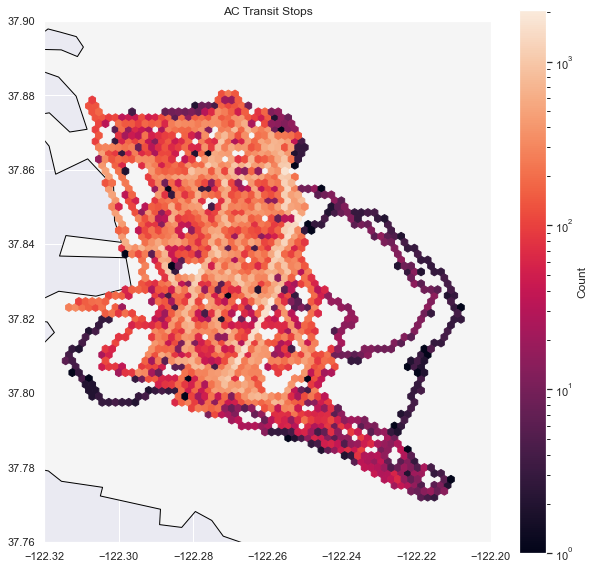

In [185]:
# plot static hexbin heatmap map of bus stops
fig, ax = plt.subplots(figsize=(10,10))

# Plot coastline using GeoPandas
outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot hexbins of bus stops using Matplotlib
hb = plt.hexbin(densify_gdf.lon, densify_gdf.lat, bins='log', mincnt=1, gridsize=60)

# Add a key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')

# Title and bounds
ax.set_title('AC Transit Stops')
ax.set_xlim((-122.32, -122.2))
ax.set_ylim((37.76, 37.9))

plt.show()

In [191]:
for i in range(1,5):
    print(i)

1
2
3
4


## TESTING

In [186]:
# plot routes
# multi = trips_gdf.loc[trips_gdf.start_region=="San Jose"].geometry.unary_union

In [187]:
# multi = gpd.GeoSeries(multi)
# multi_df = gpd.GeoDataFrame(crs=crs, geometry=gpd.GeoSeries(multi))
# multi_df.geometry.explode()

In [188]:
# multi_df.head()

In [189]:
# list(trips_gdf.iloc[0].geometry.coords)

In [147]:
trips_gdf.iloc[0].geometry.interpolate(0).wkt

'POINT (-211500.4874227013 -22884.14504526602)'

In [148]:
list(trips_gdf.iloc[0].geometry.coords)[0]

(-211500.48742270132, -22884.14504526602)

In [141]:
x = 646
while x > 0:
    print(x)
    x -= 50

646
596
546
496
446
396
346
296
246
196
146
96
46


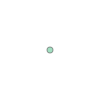

In [142]:
trips_gdf.iloc[0].geometry.interpolate(0.75, normalized=True)

* expand groupby df (1 row with 4 counts of linestring to 4 rows of 1 count of linestring)
*

In [ ]:
# https://gis.stackexchange.com/questions/238533/how-do-i-extract-points-from-a-linestring-or-polygon-data-frame-and-make-a-dicti
def linestring_to_points(feature,line):
    return {feature:line.coords}

gdf['points'] = gdf.apply(lambda l: linestring_to_points(l['xs_ID],l['geometry']),axis=1)

In [ ]:
multi_df.plot(figsize=(9,9), cmap='cubehelix')

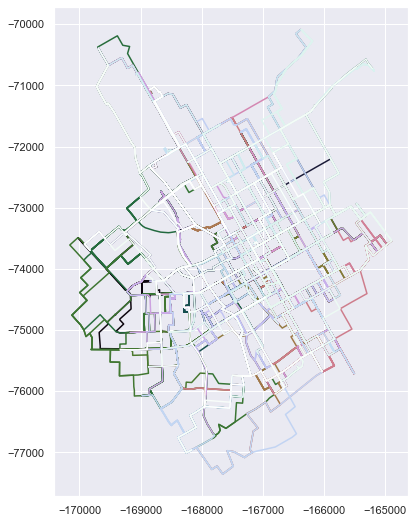

In [153]:
trips_gdf.loc[trips_gdf.start_region=="San Jose"].geometry.explode().plot(figsize=(9,9), cmap='cubehelix')

In [175]:
lines_split = []
for geom in trips_gdf.loc[trips_gdf.start_region=="East Bay"].geometry.unary_union:
    lines_split.append(geom)
print(len(lines_split))

5189


In [97]:
print(len(trips_gdf.loc[trips_gdf.start_region=="San Jose"]))

1185


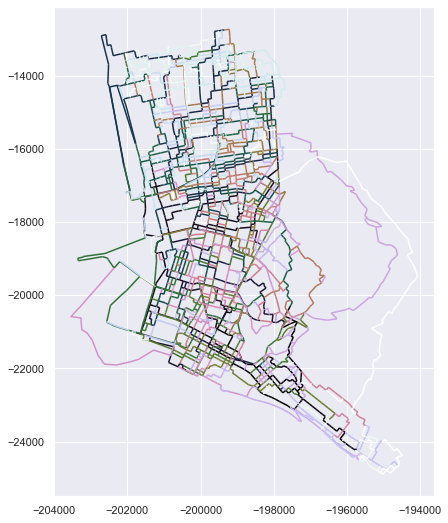

In [181]:
split_gdf = gpd.GeoDataFrame(crs=crs, geometry=lines_split)
split_gdf = split_gdf.to_crs('epsg:4326')
split_gdf.plot(figsize=(9,9), cmap='cubehelix')

In [90]:
polys1 = gpd.GeoSeries([Polygon([(0,0), (2,0), (2,2), (0,2)]),Polygon([(2,2), (4,2), (4,4), (2,4)])])
polys2 = gpd.GeoSeries([Polygon([(1,1), (3,1), (3,3), (1,3)]),Polygon([(3,3), (5,3), (5,5), (3,5)])])
df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})
df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})
# merge the two GeoDataframe
cloudNshadow = gpd.overlay(df1, df2, how='union')
print(cloudNshadow)

   df1  df2                                           geometry
0  1.0  1.0  POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....
1  2.0  1.0  POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3....
2  2.0  2.0  POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4....
3  1.0  NaN  POLYGON ((0.00000 0.00000, 0.00000 2.00000, 1....
4  2.0  NaN  MULTIPOLYGON (((2.00000 3.00000, 2.00000 4.000...
5  NaN  1.0  MULTIPOLYGON (((1.00000 2.00000, 1.00000 3.000...
6  NaN  2.0  POLYGON ((3.00000 4.00000, 3.00000 5.00000, 5....


In [91]:
print(cloudNshadow.geometry.unary_union.wkt) 

POLYGON ((0 0, 0 2, 1 2, 1 3, 2 3, 2 4, 3 4, 3 5, 5 5, 5 3, 4 3, 4 2, 3 2, 3 1, 2 1, 2 0, 0 0))


## Testing below:

In [83]:
# trips_eb.head()
# ox.get_nearest_node(G, (trips_eb.iloc[100]['start_station_latitude'], trips_eb.iloc[100]['start_station_longitude']), )

In [85]:
# trips_eb.iloc[0]['start_station_latitude'], trips_eb.iloc[0]['start_station_longitude']

In [84]:
# trips_eb['origin_node'] = trips_eb.apply(lambda x: ox.get_nearest_node(G, (x.start_station_latitude, x.start_station_longitude)))

In [53]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.868666, -122.259166) # Bancroft and Telegraph
destination_point = (37.851554, -122.252280) # College and Alcatraz
origin_node = ox.get_nearest_node(G0, origin_point)
destination_node = ox.get_nearest_node(G0, destination_point)
origin_node, destination_node

(53080628, 5486906949)

In [55]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G0, origin_node, destination_node, weight='length')
str(route)

'[53080628, 394220748, 53006324, 53103804, 53063553, 53041092, 4621435721, 53020976, 275804265, 53082748, 53085618, 53079150, 53111890, 53099277, 5060958939, 53070407, 53103280, 56837383, 53100516, 53037921, 53082594, 53100520, 53100523, 53090686, 3245435930, 3245435929, 53070069, 53090689, 5486906949]'

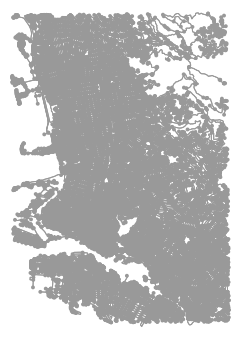

In [95]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G1, route, origin_point=origin_point, destination_point=destination_point)

In [88]:
# define a lat-long point, create network around point, define origin/destination nodes
location_point = (37.791427, -122.410018)
G = ox.graph_from_point(location_point, distance=500, distance_type='network', network_type='bike')

In [89]:
# define origin/desination points then get the nodes nearest to each
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(65343969, 65290756)

In [90]:
# find the shortest path between origin and destination nodes
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)

'[65343969, 65307397, 65295324, 65295320, 65295314, 7332987498, 7332987493, 6319217963, 6319217961, 6319217960, 65319944, 6319217971, 65290756]'

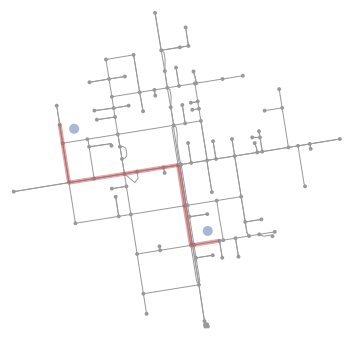

In [91]:
# plot the route showing origin/destination lat-long points in blue
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

## How to save to .html file...don't delete yet

In [103]:
from IPython.display import IFrame

In [167]:
# download the street network for Piedmont, CA
G = ox.graph_from_place('Berkeley, California, USA', network_type='bike', retain_all='False', simplify=True)

In [164]:
G?

In [129]:
# plot the street network with folium
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)

In [130]:
# save as html file then display map as an iframe
filepath = '../data/graph.html'
graph_map.save(filepath)
# IFrame(filepath, width=600, height=500)

In [220]:
# use networkx to calculate the shortest path between two nodes
origin_point = (37.868719, -122.259174)
origin_node = ox.get_nearest_node(G, origin_point)
destination_point = (37.851623, -122.252217)
destination_node = ox.get_nearest_node(G, destination_point)
# origin_node = list(G.nodes())[0]
# destination_node = list(G.nodes())[-1]
route = nx.shortest_path(G, origin_node, destination_node, weight="length")

In [221]:
print(origin_point, destination_point)
print(origin_node, destination_node)
print(route)

(37.868719, -122.259174) (37.851623, -122.252217)
53080628 5486906949
[53080628, 53099275, 53063555, 53041093, 53020977, 53020979, 4631429373, 5484497299, 53070406, 53070407, 2415284475, 56837380, 4551722985, 53037916, 53037919, 53082593, 53103284, 283272945, 283272947, 53100523, 53099164, 53090689, 5486906949]


In [222]:
# plot the route with folium
# route_map = ox.plot_route_folium(G, route)

# plot the route with folium on top of the previously created graph_map
route_graph_map = ox.plot_route_folium(G, route, route_map=graph_map, popup_attribute='length')

In [223]:
# save as html file then display map as an iframe
filepath = '../data/route_graph.html'
route_graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

In [214]:
point2 = (37.790495, -122.408353)
point2 = (37.888433, -122.272654)
ox.get_nearest_node(G, point2, return_dist=True)

(348192780, 0.04533549020388037)

LINESTRING (-122.2591864 37.8687053, -122.2590046 37.8678138, -122.258817 37.8669135, -122.2586383 37.8660287, -122.2584543 37.8651268, -122.2578102 37.8652096, -122.2577527 37.8646457, -122.257711 37.8642071, -122.2576343 37.8633691, -122.2574514 37.861562, -122.2573647 37.8615673, -122.2570972 37.8604184, -122.257095 37.860393, -122.2570407 37.8597622, -122.2558087 37.859843, -122.2556922 37.8581643, -122.2555109 37.8567252, -122.2550331 37.8558607, -122.2549659 37.8558232, -122.2540224 37.855943, -122.2537792 37.8537702, -122.2527488 37.8539022, -122.2525226 37.851636)


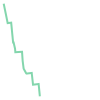

In [228]:
# https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html
from shapely.geometry import LineString, Point

gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
# path = nx.shortest_path(G, list(G.nodes())[0], list(G.nodes())[1])
route_nodes = gdf_nodes.loc[route]

route_line = LineString(list(route_nodes.geometry.values))
print(route_line)
route_line

# DONT DELETE CELL THIS MAY BE USEFUL!

In [218]:
print(gdf_nodes.y.min(), gdf_nodes.y.max())
print(gdf_nodes.x.min(), gdf_nodes.x.max())

37.8463312 37.9046164
-122.3195267 -122.2359026
